<a href="https://colab.research.google.com/github/RicksonMonteiroENCAUT/API_PRICE_PREDICT_SP_PROPERTIES_/blob/master/SaoPauloPricesPredict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Download dataset

In [1]:
!pip install kaggle

In [6]:
!cp /content/kaggle.json ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets download "argonalyst/sao-paulo-real-estate-sale-rent-april-2019"

  0% 0.00/206k [00:00<?, ?B/s]
100% 206k/206k [00:00<00:00, 33.6MB/s]


In [10]:
!unzip sao-paulo-real-estate-sale-rent-april-2019

Archive:  sao-paulo-real-estate-sale-rent-april-2019.zip
  inflating: sao-paulo-properties-april-2019.csv  


#Importando libs

In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from pickle import dump


sns.set_style('darkgrid')

In [46]:
df = pd.read_csv('/content/sao-paulo-properties-april-2019.csv')

In [48]:
df.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude
0,930,220,47,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.543138,-46.479486
1,1000,148,45,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.550239,-46.480718
2,1000,100,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.542818,-46.485665
3,1000,200,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.547171,-46.483014
4,1300,410,55,2,2,1,1,1,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.525025,-46.482436


# Dicionário de variáveis

`Price` - preço

`Condo` - Despezas de condomínio

`Size` - O tamanho da propriedade em metros quadrados m² (somente áreas privadas)

`Rooms` - Quantidade de quartos

`Toilets`- Número de banheiros

`Suites`- Número de suítes

`Parking`- Número de vagas de estacionamento

`Elevator`- Se possui elevador na construção ou não

`Furnished`- Casa mobiliada ou não

`Swimming Pool`- Se possui piscina ou não

`New` - Nova ou não

`District` - Tipo de negociação (Aluguel ou Venda)

`Property Type` - Tipo de propiedade

`Longitude` - Longitude

`Latidude` - Latitude

In [49]:
df.shape

(13640, 16)

Conjunto possui 13640 entradas e 16 colunas.

#Data clean

In [50]:
df.isnull().sum()

Price               0
Condo               0
Size                0
Rooms               0
Toilets             0
Suites              0
Parking             0
Elevator            0
Furnished           0
Swimming Pool       0
New                 0
District            0
Negotiation Type    0
Property Type       0
Latitude            0
Longitude           0
dtype: int64

In [51]:
df.dtypes

Price                 int64
Condo                 int64
Size                  int64
Rooms                 int64
Toilets               int64
Suites                int64
Parking               int64
Elevator              int64
Furnished             int64
Swimming Pool         int64
New                   int64
District             object
Negotiation Type     object
Property Type        object
Latitude            float64
Longitude           float64
dtype: object

In [52]:
df['Parking'].unique()

array([1, 2, 3, 4, 5, 6, 8, 9, 0, 7])

In [53]:
def outlier_tratament(serie):
  Q1, Q3 = serie.quantile([.25,.75])
  IQR =Q3-Q1
          #(lower_limit, upper_limit)
  return  (Q1 -(1.5*IQR), Q3 + (1.5*IQR))

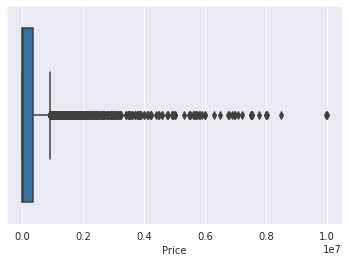

In [54]:
sns.boxplot(x='Price', data=df)

In [55]:
lower, upper = outlier_tratament(df.Price)

In [56]:
print(lower, upper)

-535353.125 897211.875


In [57]:
df_clean = df.loc[(df.Price>lower) & (df.Price<upper)].copy()
df_clean.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude
0,930,220,47,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.543138,-46.479486
1,1000,148,45,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.550239,-46.480718
2,1000,100,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.542818,-46.485665
3,1000,200,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.547171,-46.483014
4,1300,410,55,2,2,1,1,1,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.525025,-46.482436


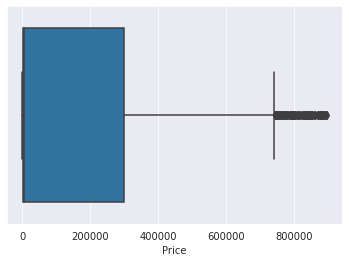

In [58]:
sns.boxplot(x='Price', data=df_clean)

Não foi encontrados valores ausentes nas variáveis, entranto a variável alvo (Prices) apresentou muitos outliers. Foi possível remover alguns utilizando a técnica de IQR score.

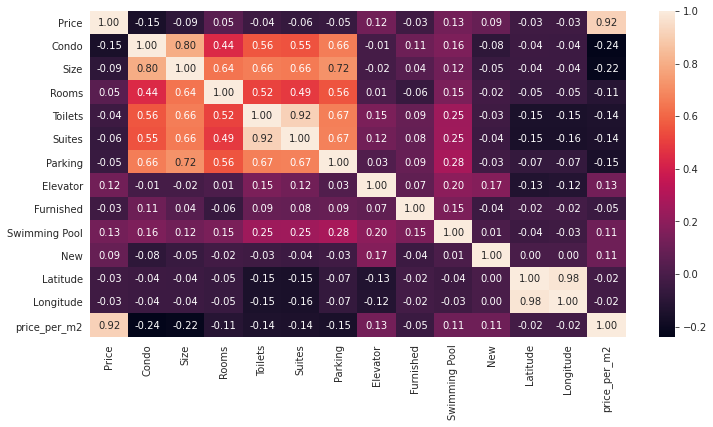

In [67]:
plt.figure(figsize=(12,6))
sns.heatmap(df_clean.corr(), annot=True, fmt='.2f')

#Feature Engineering

In [59]:
df_clean['price_per_m2'] = df_clean['Price']/df_clean['Size'] 

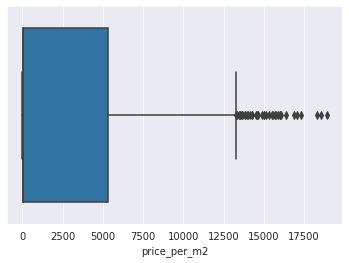

In [60]:
sns.boxplot(x='price_per_m2', data=df_clean)

In [62]:
df_clean.shape

(12617, 17)

In [63]:
df_clean['Parking'].unique()

array([1, 2, 3, 4, 5, 6, 8, 9, 0, 7])

In [68]:
df_clean['District']=df_clean['District'].apply(lambda x: x.split('/')[0])

In [69]:
df_clean

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude,price_per_m2
0,930,220,47,2,2,1,1,0,0,0,0,Artur Alvim,rent,apartment,-23.543138,-46.479486,19.787234
1,1000,148,45,2,2,1,1,0,0,0,0,Artur Alvim,rent,apartment,-23.550239,-46.480718,22.222222
2,1000,100,48,2,2,1,1,0,0,0,0,Artur Alvim,rent,apartment,-23.542818,-46.485665,20.833333
3,1000,200,48,2,2,1,1,0,0,0,0,Artur Alvim,rent,apartment,-23.547171,-46.483014,20.833333
4,1300,410,55,2,2,1,1,1,0,0,0,Artur Alvim,rent,apartment,-23.525025,-46.482436,23.636364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13635,265000,420,51,2,1,0,1,0,0,0,0,Jabaquara,sale,apartment,-23.653004,-46.635463,5196.078431
13636,545000,630,74,3,2,1,2,0,0,1,0,Jabaquara,sale,apartment,-23.648930,-46.641982,7364.864865
13637,515000,1100,114,3,3,1,1,0,0,1,0,Jabaquara,sale,apartment,-23.649693,-46.649783,4517.543860
13638,345000,48,39,1,2,1,1,0,1,1,0,Jabaquara,sale,apartment,-23.652060,-46.637046,8846.153846


In [70]:
categoricas=df_clean.select_dtypes('object').columns

In [71]:
categoricas

Index(['District', 'Negotiation Type', 'Property Type'], dtype='object')

In [75]:
df['Property Type'].value_counts(normalize=True)

apartment    1.0
Name: Property Type, dtype: float64

In [72]:
df_clean = pd.get_dummies(df_clean)

In [78]:
df_clean.drop(['Property Type_apartment'],axis=1, inplace=True)

In [79]:
df_clean.drop(['Latitude', 'Longitude'],axis=1, inplace=True)

In [93]:
df_clean

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,price_per_m2,District_Alto de Pinheiros,District_Anhanguera,District_Aricanduva,District_Artur Alvim,District_Barra Funda,District_Bela Vista,District_Belém,District_Bom Retiro,District_Brasilândia,District_Brooklin,District_Brás,District_Butantã,District_Cachoeirinha,District_Cambuci,District_Campo Belo,District_Campo Grande,District_Campo Limpo,District_Cangaíba,District_Capão Redondo,District_Carrão,District_Casa Verde,District_Cidade Ademar,District_Cidade Dutra,District_Cidade Líder,District_Cidade Tiradentes,District_Consolação,District_Cursino,District_Ermelino Matarazzo,...,District_Perdizes,District_Perus,District_Pinheiros,District_Pirituba,District_Ponte Rasa,District_Raposo Tavares,District_República,District_Rio Pequeno,District_Sacomã,District_Santa Cecília,District_Santana,District_Santo Amaro,District_Sapopemba,District_Saúde,District_Socorro,District_São Domingos,District_São Lucas,District_São Mateus,District_São Miguel,District_São Rafael,District_Sé,District_Tatuapé,District_Tremembé,District_Tucuruvi,District_Vila Andrade,District_Vila Curuçá,District_Vila Formosa,District_Vila Guilherme,District_Vila Jacuí,District_Vila Leopoldina,District_Vila Madalena,District_Vila Maria,District_Vila Mariana,District_Vila Matilde,District_Vila Olimpia,District_Vila Prudente,District_Vila Sônia,District_Água Rasa,Negotiation Type_rent,Negotiation Type_sale
0,930,220,47,2,2,1,1,0,0,0,0,19.787234,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,1000,148,45,2,2,1,1,0,0,0,0,22.222222,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,1000,100,48,2,2,1,1,0,0,0,0,20.833333,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,1000,200,48,2,2,1,1,0,0,0,0,20.833333,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,1300,410,55,2,2,1,1,1,0,0,0,23.636364,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13635,265000,420,51,2,1,0,1,0,0,0,0,5196.078431,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
13636,545000,630,74,3,2,1,2,0,0,1,0,7364.864865,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
13637,515000,1100,114,3,3,1,1,0,0,1,0,4517.543860,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
13638,345000,48,39,1,2,1,1,0,1,1,0,8846.153846,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


A variável `Property Type` possuía todos os valores identicos, por isso foi removida. 

As variáveis `Latitude` e `Longitude` permitem realizar alguns tipos de análise baseado na localização de cada imóvel, o que não é o intuito aqui. Por conta disso foram removidas.

A relação entre as variáveis `price` e `size` trazem uma informação importante. O `price_per_m2` traz o preço do metro quadrado daquele imóvel e pode ajudar o modelo assimilar informações importantes sobre os imóveis.

#Create pipeline

In [90]:
X = df_clean.drop(['Price'], axis=1)
y = df_clean['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y) 

In [110]:
pipeline = Pipeline([('scaler', StandardScaler()), ('clf', XGBRegressor(objective='reg:squarederror'))]) 

In [94]:
pipeline.fit(X_train, y_train)

[19:30:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0,
                              importance_type='gain', learning_rate=0.1,
                              max_delta_step=0, max_depth=3, min_child_weight=1,
                              missing=None, n_estimators=100, n_jobs=1,
                              nthread=None, objective='reg:linear',
                              random_state=0, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, seed=None, silent=None,
                              subsample=1, verbosity=1))],
         verbose=False)

In [95]:
y_pred = pipeline.predict(X_test) 

In [99]:
print('R2', r2_score(y_test, y_pred))
print('MAE: ',mean_absolute_error(y_test, y_pred))
print('MSE: ',mean_squared_error(y_test, y_pred))
print('RMSE: ',np.sqrt(mean_squared_error(y_test, y_pred)))

R2 0.9973855798825335
MAE:  5732.036639370443
MSE:  130575209.96288237
RMSE:  11426.951035288563


In [102]:
param_grid={
    'learning_rate':[0.001, 0.01, 1],
    'max_depth:': range(1,10),
    'gamma': [i/10 for i in range(0,10)],
    'n_estimators' : range(0,600,50),
    'subsample': [i/10 for i in range(5, 11)],
    'colsample_bytree': [i/10 for i in range(5, 11)],
    'min_child_weight': range(1,5),
    'scale_pos_weight': [i/10 for i in range(0,100,5)]

}

<bound method Pipeline.get_params of Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0,
                              importance_type='gain', learning_rate=0.1,
                              max_delta_step=0, max_depth=3, min_child_weight=1,
                              missing=None, n_estimators=100, n_jobs=1,
                              nthread=None, objective='reg:linear',
                              random_state=0, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, seed=None, silent=None,
                              subsample=1, verbosity=1))],
         verbose=False)>

#Hyperparam Tuning

In [111]:
pipeline = Pipeline([('scaler', StandardScaler()), ('clf', XGBRegressor(objective='reg:squarederror'))])
grid = GridSearchCV(pipeline, scoring='neg_mean_squared_error', param_grid={'clf__n_estimators' : range(0,600,50)})
grid.fit(X_train, y_train)
print('neg_mean_squared_error: {}'.format(grid.best_score_ ))
print('best_params: {}'.format(grid.best_params_))

neg_mean_squared_error: -72061017.97618322
best_params: {'clf__n_estimators': 550}


In [114]:
pipeline = Pipeline([('scaler', StandardScaler()), ('clf', XGBRegressor(n_estimators=550,objective='reg:squarederror'))])
grid = GridSearchCV(pipeline.set_params(), scoring='neg_mean_squared_error', param_grid={
                                                                                'clf__min_child_weight': range(1,5)})
grid.fit(X_train, y_train)
print('neg_mean_squared_error: {}'.format(grid.best_score_ ))
print('best_params: {}'.format(grid.best_params_))

neg_mean_squared_error: -67511987.95444188
best_params: {'clf__min_child_weight': 3}


In [116]:
pipeline = Pipeline([('scaler', StandardScaler()), ('clf', XGBRegressor(n_estimators=550, min_child_weight=3, objective='reg:squarederror'))])
grid = GridSearchCV(pipeline.set_params(), scoring='neg_mean_squared_error', param_grid={
                                                                               'clf__scale_pos_weight': [i/10 for i in range(0,100,5)]})
grid.fit(X_train, y_train)
print('neg_mean_squared_error: {}'.format(grid.best_score_ ))
print('best_params: {}'.format(grid.best_params_))

neg_mean_squared_error: -67511987.95444188
best_params: {'clf__scale_pos_weight': 0.0}


In [117]:
pipeline = Pipeline([('scaler', StandardScaler()), ('clf', XGBRegressor(n_estimators=550, min_child_weight=3, scale_pos_weight=0, objective='reg:squarederror'))])
grid = GridSearchCV(pipeline.set_params(), scoring='neg_mean_squared_error', param_grid={
                                                                            'clf__max_depth:': range(1,10)})
grid.fit(X_train, y_train)
print('neg_mean_squared_error: {}'.format(grid.best_score_ ))
print('best_params: {}'.format(grid.best_params_))

neg_mean_squared_error: -67511987.95444188
best_params: {'clf__max_depth:': 1}


In [118]:
pipeline = Pipeline([('scaler', StandardScaler()), ('clf', XGBRegressor(n_estimators=550, min_child_weight=3, scale_pos_weight=0, max_depht=1, objective='reg:squarederror'))])
grid = GridSearchCV(pipeline.set_params(), scoring='neg_mean_squared_error', param_grid={'clf__gamma': [i/10 for i in range(0,10)]})
grid.fit(X_train, y_train)
print('neg_mean_squared_error: {}'.format(grid.best_score_ ))
print('best_params: {}'.format(grid.best_params_))

neg_mean_squared_error: -67511987.95444188
best_params: {'clf__gamma': 0.0}


In [119]:
pipeline = Pipeline([('scaler', StandardScaler()), ('clf', XGBRegressor(n_estimators=550, min_child_weight=3, scale_pos_weight=0, max_depht=1, gamma=0,objective='reg:squarederror'))])
grid = GridSearchCV(pipeline.set_params(), scoring='neg_mean_squared_error', param_grid={
                                                                             'clf__subsample': [i/10 for i in range(5, 11)]})
grid.fit(X_train, y_train)
print('neg_mean_squared_error: {}'.format(grid.best_score_ ))
print('best_params: {}'.format(grid.best_params_))

neg_mean_squared_error: -60282304.201571845
best_params: {'clf__subsample': 0.7}


In [120]:
pipeline = Pipeline([('scaler', StandardScaler()), ('clf', XGBRegressor(n_estimators=550, min_child_weight=3, scale_pos_weight=0, max_depht=1, gamma=0, subsample=0.7,objective='reg:squarederror'))])
grid = GridSearchCV(pipeline.set_params(), scoring='neg_mean_squared_error', param_grid={
                                                                             'clf__colsample_bytree': [i/10 for i in range(5, 11)]})
grid.fit(X_train, y_train)
print('neg_mean_squared_error: {}'.format(grid.best_score_ ))
print('best_params: {}'.format(grid.best_params_))

neg_mean_squared_error: -60282304.201571845
best_params: {'clf__colsample_bytree': 1.0}


In [121]:
pipeline = Pipeline([('scaler', StandardScaler()), ('clf', XGBRegressor(n_estimators=550, min_child_weight=3, scale_pos_weight=0, max_depht=1, gamma=0, subsample=0.7, colsample_bytree= 1,objective='reg:squarederror'))])
grid = GridSearchCV(pipeline.set_params(), scoring='neg_mean_squared_error', param_grid={
                                                                             'clf__learning_rate': [0.001, 0.01, 0.1, 0.2,0.3, 1]})
grid.fit(X_train, y_train)
print('neg_mean_squared_error: {}'.format(grid.best_score_ ))
print('best_params: {}'.format(grid.best_params_))

neg_mean_squared_error: -60282304.201571845
best_params: {'clf__learning_rate': 0.1}


In [122]:
pipeline = Pipeline([('scaler', StandardScaler()), ('clf', XGBRegressor(learning_rate=0.1,n_estimators=550, min_child_weight=3, scale_pos_weight=0, max_depht=1, gamma=0, subsample=0.7, colsample_bytree= 1,objective='reg:squarederror'))])
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0,
                              importance_type='gain', learning_rate=0.1,
                              max_delta_step=0, max_depht=1, max_depth=3,
                              min_child_weight=3, missing=None,
                              n_estimators=550, n_jobs=1, nthread=None,
                              objective='reg:squarederror', random_state=0,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=0,
                              seed=None, silent=None, subsample=0.7,
                              verbosity=1))],
         verbose=False)

In [125]:
y_pred = pipeline.predict(X_test)

In [126]:
print('R2', r2_score(y_test, y_pred))
print('MAE: ',mean_absolute_error(y_test, y_pred))
print('MSE: ',mean_squared_error(y_test, y_pred))
print('RMSE: ',np.sqrt(mean_squared_error(y_test, y_pred)))

R2 0.9990385912550938
MAE:  3206.794322155319
MSE:  48016823.26707628
RMSE:  6929.417238633872


#Save features and model

In [159]:
dump(pipeline, open('pipeline.pkl', 'wb'))

In [160]:
features = X_train.columns
dump(features, open('features.pkl', 'wb'))

In [151]:
element=json.dumps(dict(zip(X_train.columns.values, np.zeros(X_train.shape[0]).astype(int).tolist())), indent=4)
print(element)

{
    "Condo": 0,
    "Size": 0,
    "Rooms": 0,
    "Toilets": 0,
    "Suites": 0,
    "Parking": 0,
    "Elevator": 0,
    "Furnished": 0,
    "Swimming Pool": 0,
    "New": 0,
    "price_per_m2": 0,
    "District_Alto de Pinheiros": 0,
    "District_Anhanguera": 0,
    "District_Aricanduva": 0,
    "District_Artur Alvim": 0,
    "District_Barra Funda": 0,
    "District_Bela Vista": 0,
    "District_Bel\u00e9m": 0,
    "District_Bom Retiro": 0,
    "District_Brasil\u00e2ndia": 0,
    "District_Brooklin": 0,
    "District_Br\u00e1s": 0,
    "District_Butant\u00e3": 0,
    "District_Cachoeirinha": 0,
    "District_Cambuci": 0,
    "District_Campo Belo": 0,
    "District_Campo Grande": 0,
    "District_Campo Limpo": 0,
    "District_Canga\u00edba": 0,
    "District_Cap\u00e3o Redondo": 0,
    "District_Carr\u00e3o": 0,
    "District_Casa Verde": 0,
    "District_Cidade Ademar": 0,
    "District_Cidade Dutra": 0,
    "District_Cidade L\u00edder": 0,
    "District_Cidade Tiradentes": 0,
 

In [176]:
pipeline.predict([[ 500, 50, 4, 3,    2,    1,    0,    0,    1,    0, 5000,    0,    0,    0,
     0,    0,    0,     0,   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
     0,    0,    0,     0,   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
     0,    0,    0,     0,   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
     0,    0,    0,     0,   0,    0,    0,    0,    1,    0,    0,    0,    0,    0,
     0,    0,    0,     0,   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
     0,    0,    0,     0,   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
     0,    0,    0,     0,   0,    0,    0,    0,    0,    0,    1]])

array([248783.05], dtype=float32)